In [1]:
import sys
sys.path.append("..")

In [2]:
from squlearn.encoding_circuit.encoding_circuit_derivatives import *

import numpy as np
from scipy.integrate import odeint
from solvers.MMR.kernel_solver import Solver
from solvers.MMR.PQK_solver import PQK_solver
from solvers.MMR.FQK_solver import FQK_solver
from DE_Library.diferential_equation_functionals import *

from utils.rbf_kernel_tools import *
from circuits.circuits import *

import matplotlib.pyplot as plt

To run this notebook it is necessary to have installed my branch of squlearn installed

In [3]:

def loss_log_ode(f_alpha_tensor, x_span = None):
    """
    0 = lamb * np.exp(f * k) - df/dx
    f(0.001) = np.log(0.001)

    solution: f(x) = np.log(x)
    """
    if x_span is None: #Then, we are using a QNN
        loss_values = f_alpha_tensor #f_alpha_tensor is the loss_values dictionary
        x = loss_values["x"]
        f = loss_values["f"]
        dfdx = loss_values["dfdx"][:,0]
    else: #Then, we are using a Kernel
        x = x_span
        f = f_alpha_tensor[0]
        dfdx = f_alpha_tensor[1]

    lamb = 1
    k = 1
    return dfdx - np.exp(-f*k)*lamb 

def grad_loss_log_ode(loss_values, x_span = None):
    """
    n = x_span.shape[0] number of points
    m = x_span.shape[1] number of dimensions (typically m=1)

    F[x, x_, x__] = F(x, x_, x__)

    grad_F = (F(x, x_, x__)dx, F(x, x_, x__)dx_, F(x, x_, x__)dx__)

    F = lamb * np.exp(f * k) - df/dx

    grad_F = (-lamb*k, -1, 0)
    """
    lamb = 1
    k = 1
    x, f, dfdx, dfdxdx = get_differentials(loss_values, x_span)

    dFdf = lamb*k*np.exp(-f*k)
    dFdfdx = 1
    dFdfdxdx = 0

    dfdp = loss_values["dfdp"] # shape (n, p)
    n_param = dfdp.shape[1]
    
    grad_envelope_list = np.zeros((3, x.shape[0], n_param)) # shape (3, n, p)
    grad_envelope_list[0,:,:] = np.tile(dFdf, (n_param, 1)).T  
    grad_envelope_list[1,:,:] = np.tile(dFdfdx, (n_param, 1)).T
    grad_envelope_list[2,:,:] =  np.tile(dFdfdxdx, (n_param, 1)).T
    return grad_envelope_list

def derivatives_loss_log_ode(f_alpha_tensor, x_span = None):
    """
    0 = lamb * np.exp(f * k) - df/dx
    f(0.001) = np.log(0.001)

    solution: f(x) = np.log(x)
    """
    f = f_alpha_tensor[0]
    lamb = 1
    k = 1
    return [np.exp(-f*k)*lamb]


In [5]:
x_line = np.linspace(0.1, 1, 20)
f_initial = [np.log(x_line[0])]


#Classical Solver
#RBF
RBF_kernel_list = [rbf_kernel_manual(x_line, x_line, sigma = 0.2), analytical_derivative_rbf_kernel(x_line, x_line, sigma = 0.2), analytical_derivative_rbf_kernel_2(x_line, x_line, sigma = 0.2)]
Solver_test = Solver(RBF_kernel_list, regularization_parameter=1)
solution_RBF, _ = Solver_test.solver(x_line, f_initial, L_functional = loss_log_ode)
f_RBF, optimal_alpha_RBF = solution_RBF[0], solution_RBF[1] #fix bug here


#PQK
sigma_list = np.linspace(0.1, 1, 70)
mse_list = np.zeros_like(sigma_list)
#for idx, sigma in enumerate(sigma_list):
sigma = 1.5


PQK_solver_test = PQK_solver({"encoding_circuit": Separable_rx_qiskit, 
                            "num_qubits": 8,
                            "num_layers": 2,
                            },
                            Executor("pennylane"), 
                            envelope={"function": rbf_kernel_manual, 
                                        "derivative_function": analytical_derivative_rbf_kernel, 
                                        "second_derivative_function": analytical_derivative_rbf_kernel_2,
                                        "sigma": sigma})


solution_PQK, kernel_list_PQK = PQK_solver_test.solver(x_line, f_initial, L_functional = loss_log_ode)
f_PQK, optimal_alpha_PQK = solution_PQK[0] ##fix bug here
#mse_list[idx] = np.mean((f_PQK - f_odeint)**2)




    # = solution_PQK[1]


FQK_solver_test = FQK_solver({"encoding_circuit": HardwareEfficientEmbeddingCircuit_qiskit, 
                              "num_qubits": 7, #6
                              "num_layers": 2,
                              },
                              Executor("pennylane"),)
solution_FQK, kernel_listFQK = FQK_solver_test.solver(x_line, f_initial, loss_log_ode)
f_FQK, optimal_alpha_FQK = solution_FQK[0]


f_odeint = odeint(derivatives_loss_log_ode, f_initial, x_line[:])



x_span_plot = x_line.reshape(-1, 1)
plt.plot(x_span_plot, f_odeint, "-*",label="odeint")
plt.plot(x_span_plot, f_RBF, "x", label="RBF")
plt.plot(x_span_plot, f_PQK, label="PQK")
#plt.plot(x_span_plot, f_FQK, "-x",label="FQK")
plt.plot(x_span_plot, np.log(x_span_plot), label="log(x)")
#plt.ylim(-3, 3)


plt.ylabel("f(x)")
plt.xlabel("x")

str_PQK_info = PQK_solver_test.print_plotting_relevant_info()
plt.text(1.1, 0.3, str_PQK_info, 
         bbox=dict(facecolor=f"C{1}", alpha=0.5))



plt.legend()
plt.show()





-0.0
1.1514583145575512
2.1170744197860083
2.760094162506745
3.024111195258129
2.936848175541887
2.5886603652691877
2.09735913771174
1.573817224059704
1.0990943284995962
0.7167359919622719
0.437479050851241
0.2503743243372308
0.13453474835198898
0.06794231400863966
0.03227478393665685
0.014430801707154026
0.006076540484640026
0.0024107689167119956
0.0009014691913414004
-1.1514583145575512
-0.0
1.1514583145575505
2.1170744197860083
2.760094162506745
3.0241111952581288
2.9368481755418876
2.5886603652691877
2.09735913771174
1.5738172240597053
1.0990943284995962
0.7167359919622719
0.4374790508512415
0.2503743243372308
0.13453474835198898
0.06794231400863983
0.03227478393665685
0.014430801707154026
0.006076540484640036
0.0024107689167119956
-2.1170744197860083
-1.1514583145575505
-0.0
1.1514583145575512
2.1170744197860087
2.7600941625067454
3.024111195258129
2.9368481755418876
2.5886603652691873
2.097359137711741
1.573817224059705
1.0990943284995958
0.7167359919622724
0.437479050851241
0.25

NameError: name 'L_functional_1ODE' is not defined

In [5]:
PQK_solver_test.print_plotting_relevant_info()

'PQK: Separable_rx_qiskit encoding_circuit: Separable_rx_qiskit num_qubits: 8 num_layers: 2 rbf_kernel_manual envelope: rbf_kernel_manual sigma: 1.5 '

In [6]:
params_ini_for_qnn_log = np.array([-0.8668401 ,  0.62015684, -2.15667028, -0.95454592, -2.89136728,
       -1.92620405, -2.42505116, -0.73693033,  0.15005287,  0.11193568,
       -0.05050098,  0.1663773 , -1.60720058,  2.65320097, -2.67566268,
        1.73276216, -0.50043699, -0.0168493 , -2.00266291, -1.08206438,
        1.86698375,  3.38838397, -1.28013607,  0.40042087,  2.48657952,
        1.84133399, -2.57681948, -2.25447227, -1.48390435,  2.34203517,
       -3.05758795,  0.07006922,  2.83425198,  0.51826963,  0.283995  ,
       -1.27784187,  1.79961911,  1.75086033, -2.58554971,  2.22307143,
        3.21987049,  1.26645828, -1.5382721 ,  0.61663127, -2.49837747,
        0.67758954,  1.76342976,  0.28877661, -0.44080463, -2.08639276,
       -3.71336053,  0.42384569, -1.3393165 ,  0.12151889,  0.26585592,
       -3.43308924,  0.83359602, -2.13203627,  0.78660411,  0.28519979,
       -2.34090764, -0.64527869,  0.51750895, -0.32511686, -3.35527718,
        0.22554386,  1.28212405,  0.09355113,  1.97205487,  0.54384149,
        1.71538417, -2.27781413, -2.78838724,  1.93139642, -1.72878695,
       -2.10264181,  2.15244049, -0.95651545,  1.62222138,  1.41998766])

In [7]:
from squlearn.observables import SummedPaulis
from squlearn.qnn import QNNRegressor, ODELoss
from squlearn.qnn.lowlevel_qnn import LowLevelQNN
from squlearn.optimizers import SLSQP, Adam
from squlearn.qnn.loss import *
from squlearn.qnn.training import *




num_qubits = 8
num_features = 1
num_layers = 5
circuit = YZ_CX_EncodingCircuit(num_qubits, num_features, num_layers)
executor = Executor("pennylane")

Observables = SummedPaulis(num_qubits, include_identity=False)                                                      
param_obs = Observables.generate_initial_parameters(seed=1)
param_ini = params_ini_for_qnn_log
#param_ini = circuit.generate_initial_parameters(seed=1)



slsqp = SLSQP(options={"maxiter": 150, "ftol": 0.05})
adam = Adam(options={"maxiter": 350, "tol": 0.00009})

initial_value = np.array([np.log(0.01)])
loss_ODE = ODELoss(loss_log_ode, grad_loss_log_ode, initial_vec = initial_value, eta=1)


clf = QNNRegressor(
    circuit,
    Observables,
    executor,
    loss_ODE,
    adam,
    param_ini,
    param_obs,
    opt_param_op = False, #Parametrized Observables not benchmarked yet
)

In [8]:
y_ODE = np.zeros((x_line.shape[0]))
clf._fit(x_line, y_ODE,  weights=None)
f_QNN = clf.predict(x_line)

fit:   0%|          | 0/350 [00:00<?, ?it/s]PARAM [-0.8668401   0.62015684 -2.15667028 -0.95454592 -2.89136728 -1.92620405
 -2.42505116 -0.73693033  0.15005287  0.11193568 -0.05050098  0.1663773
 -1.60720058  2.65320097 -2.67566268  1.73276216 -0.50043699 -0.0168493
 -2.00266291 -1.08206438  1.86698375  3.38838397 -1.28013607  0.40042087
  2.48657952  1.84133399 -2.57681948 -2.25447227 -1.48390435  2.34203517
 -3.05758795  0.07006922  2.83425198  0.51826963  0.283995   -1.27784187
  1.79961911  1.75086033 -2.58554971  2.22307143  3.21987049  1.26645828
 -1.5382721   0.61663127 -2.49837747  0.67758954  1.76342976  0.28877661
 -0.44080463 -2.08639276 -3.71336053  0.42384569 -1.3393165   0.12151889
  0.26585592 -3.43308924  0.83359602 -2.13203627  0.78660411  0.28519979
 -2.34090764 -0.64527869  0.51750895 -0.32511686 -3.35527718  0.22554386
  1.28212405  0.09355113  1.97205487  0.54384149  1.71538417 -2.27781413
 -2.78838724  1.93139642 -1.72878695 -2.10264181  2.15244049 -0.95651545
  1

KeyboardInterrupt: 

In [ ]:
PQK_solver_test.

In [ ]:
def get_relevant_info_text(df_row):
    df = df_row
    text = ""
    if df["method"] == "PQK":
        text += f"L: {df['CI_num_layers']}, "
        text += "$n_{qubits}$" +f": {df['CI_num_qubits']}, "
        text += f"$\gamma$:  {np.round(df['gamma'], 3)}, "
        text += f"fmap: {df['CI_encoding_circuit_label'][:-7]}"
    elif df["method"] == "FQK":
        text += f"L: {df['CI_num_layers']}, "
        text += "$n_{qubits}$" +f": {df['CI_num_qubits']}, "
        text += f"fmap: {df['CI_encoding_circuit_label'][:-7]}"
    elif df["method"] == "classical_RBF":
        text += f"$\gamma$: {np.round(df['gamma'], 3)}"
    return text

        

In [ ]:
str_PQK_info = str(get_relevant_info_text(results_PQK[results_PQK["g_name"] == "g_paper"].iloc[0]))
plt.text(1.1, 0.5, str_PQK_info, 
         bbox=dict(facecolor=f"C{0}", alpha=0.5))
str_FQK_info = str(get_relevant_info_text(results_FQK[results_FQK["g_name"] == "g_paper"].iloc[0]))
plt.text(1.1, 0.3, str_FQK_info, 
         bbox=dict(facecolor=f"C{1}", alpha=0.5))
str_RBF_info = str(get_relevant_info_text(results_RBF[results_RBF["g_name"] == "g_paper"].iloc[0]))
plt.text(1.1, 0.1, str_RBF_info, 
         bbox=dict(facecolor=f"C{2}", alpha=0.5))


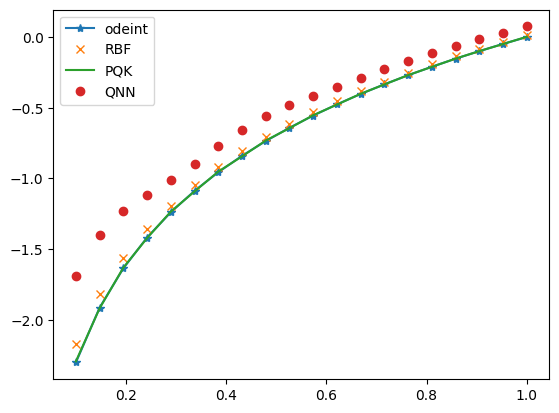

In [ ]:
plt.plot(x_span_plot, f_odeint, "-*",label="odeint")
plt.plot(x_span_plot, f_RBF, "x", label="RBF")
plt.plot(x_span_plot, f_PQK, label="PQK")
plt.plot(x_span_plot, f_QNN, "o", label="QNN")
plt.legend()